In [1]:
# using PyPlot
# include("acoustic_solver.jl")
# include("barycenter.jl")

# using Distributed
# using SharedArrays
# addprocs(11);

In [60]:
@everywhere include("inverse_prob.jl")

In [84]:
@eval @everywhere begin
Nx = 101;
Ny = 101;
h = 0.01;

Fs = 500;
dt = 1/Fs
Nt = 1001;
t = range(0, length=Nt, step=dt)

source = source_ricker(5, 0.2, t)
source_position = zeros(11,2)
for i = 1:11
    source_position[i,:] = [5 10*(i-1)+1]
end
source = repeat(source, 1, 11)

receiver_position = zeros(101,2)
for i = 1:101
    receiver_position[i,:] = [1, (i-1)*1+1]
end

c = ones(Nx, Ny)
rho = ones(Nx, Ny)
c[40:end,:] .= 1.1

c0 = ones(Nx, Ny)
rho0 = ones(Nx, Ny)
c0[60:end,:] .= 1.1
c0 = imfilter(c, Kernel.gaussian(20));

cc = ones(Nx, Ny)
rhoc = ones(Nx, Ny)

pml_len = 20
pml_coef = 100
end

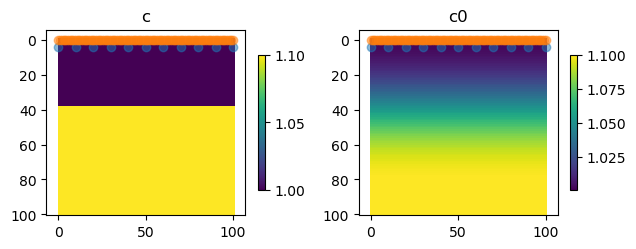

In [85]:
figure
subplot(121)
imshow(c); colorbar(shrink=0.3); title("c")
scatter(source_position[:,2].-1, source_position[:,1].-1, alpha=0.5)
scatter(receiver_position[:,2].-1, receiver_position[:,1].-1, alpha=0.5)
subplot(122)
imshow(c0); colorbar(shrink=0.3); title("c0")
scatter(source_position[:,2].-1, source_position[:,1].-1, alpha=0.5)
scatter(receiver_position[:,2].-1, receiver_position[:,1].-1, alpha=0.5)

tight_layout()

In [86]:
# @time data, u = acoustic_eq_solver(c, rho, Nx, Ny, Nt, h, dt, source, source_position, receiver_position; pml_len=10, pml_coef=100);
# @time data0, u0 = acoustic_eq_solver(c0, rho0, Nx, Ny, Nt, h, dt, source, source_position, receiver_position; pml_len=10, pml_coef=100);
# @time datac, uc = acoustic_eq_solver(cc, rhoc, Nx, Ny, Nt, h, dt, source, source_position, receiver_position; pml_len=10, pml_coef=100);

@time data, u = multi_solver_parallel(c, rho, Nx, Ny, Nt, h, dt, source, source_position, receiver_position; pml_len=10, pml_coef=100);

@time data0, u0 = multi_solver_parallel(c0, rho0, Nx, Ny, Nt, h, dt, source, source_position, receiver_position; pml_len=10, pml_coef=100);

@time datac, uc = multi_solver_parallel(cc, rhoc, Nx, Ny, Nt, h, dt, source, source_position, receiver_position; pml_len=10, pml_coef=100);


  7.284582 seconds (219.58 k allocations: 11.363 MiB, 0.37% gc time)
  5.000303 seconds (5.73 k allocations: 256.844 KiB)
  4.990164 seconds (5.73 k allocations: 256.734 KiB)


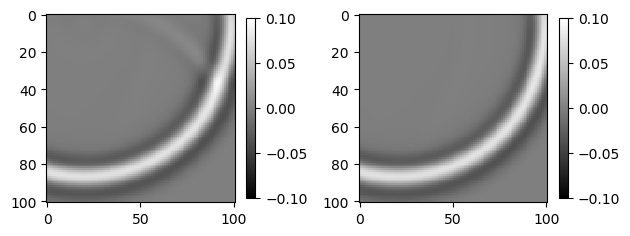

In [87]:
# figure
# subplot(221)
# imshow(data, aspect=0.1, cmap="gray"); title("data"); colorbar(shrink=0.5); clim([-0.03,0.03])

# subplot(222)
# imshow(data0, aspect=0.1, cmap="gray"); title("data0"); colorbar(shrink=0.5); clim([-0.03,0.03])

# subplot(223)
# imshow(data-datac, aspect=0.1, cmap="gray"); title("data"); colorbar(shrink=0.5); clim([-0.01,0.01])

# subplot(224)
# imshow(data0-datac, aspect=0.1, cmap="gray"); title("data0"); colorbar(shrink=0.5); clim([-0.01,0.01])

# tight_layout()
figure;
subplot(121); imshow(u[:,:,500,3],cmap=ColorMap("gray")); colorbar(shrink=0.4); clim(-0.1,0.1)
subplot(122);imshow(u0[:,:,500,3],cmap=ColorMap("gray")); colorbar(shrink=0.4); clim(-0.1,0.1)
tight_layout()

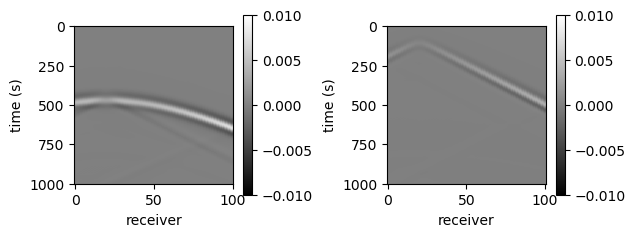

In [88]:
figure;
r_axis = 0:21
subplot(121); imshow(data[:,:,3]-1*datac[:,:,3],cmap=ColorMap("gray"), aspect=0.1); colorbar(shrink=0.4); clim([-0.01,0.01])
xlabel("receiver"); ylabel("time (s)")
subplot(122); imshow(data0[:,:,3]-1*datac[:,:,3],cmap=ColorMap("gray"), aspect=0.1); colorbar(shrink=0.4); clim([-0.01,0.01])
xlabel("receiver"); ylabel("time (s)")
tight_layout()

In [89]:
M = cost_matrix_1d(t, t; p=2)
@time adj_s, dd = adj_source_sinkhorn_parallel(data-datac, data0-datac, M; reg=5e-3, reg_m=1e2, iterMax=100, verbose=false);

 19.457255 seconds (7.46 k allocations: 42.705 MiB, 0.10% gc time)


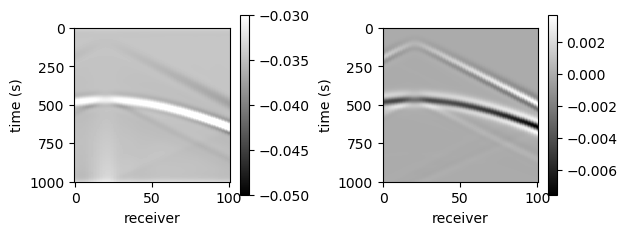

In [90]:
figure;
r_axis = 0:21
subplot(121); imshow(adj_s[:,:,3],cmap=ColorMap("gray"), aspect=0.1); colorbar(shrink=0.4); clim([-0.05, -0.03])
xlabel("receiver"); ylabel("time (s)")
subplot(122); imshow(data0[:,:,3]-data[:,:,3],cmap=ColorMap("gray"), aspect=0.1); colorbar(shrink=0.4);
xlabel("receiver"); ylabel("time (s)")
tight_layout()

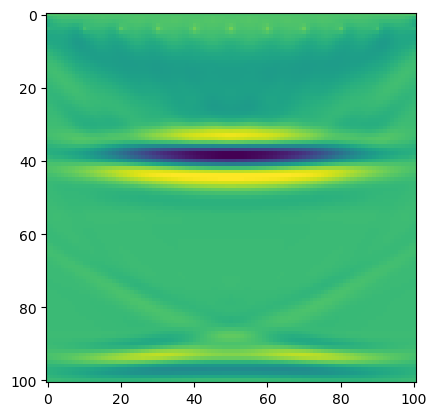

 31.674323 seconds (11.35 k allocations: 8.415 GiB, 1.64% gc time)


PyObject <matplotlib.image.AxesImage object at 0x7fa6679e75f8>

In [91]:
@time gg, dd = grad_sinkhorn_parallel(data-datac, u, data0-datac, c, rho, Nx, Ny, Nt, h, dt, source_position, receiver_position; pml_len=10, pml_coef=100, reg=1e-3, reg_m=1e2, iterMax=100, verbose=false);

imshow(gg)

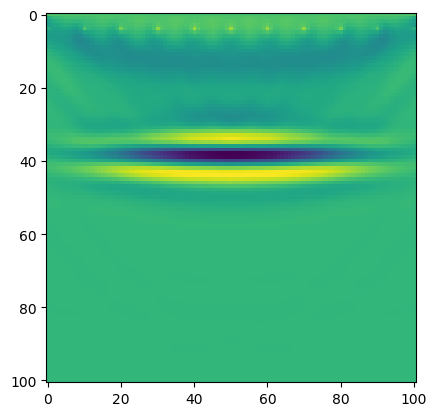

 33.970367 seconds (2.21 M allocations: 123.595 GiB, 28.42% gc time)


PyObject <matplotlib.image.AxesImage object at 0x7fa66795a518>

In [92]:
@time ggl = grad_l2(data, u, data0, c, rho, Nx, Ny, Nt, h, dt, source_position, receiver_position; pml_len=10, pml_coef=100);
imshow(ggl)

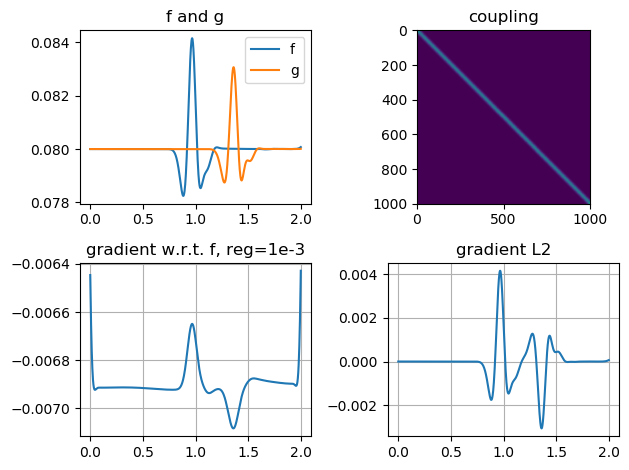

In [83]:
ind1 = 21
f = data[:,ind1,1]-datac[:,ind1,1] .+ 0.08
g = data0[:,ind1,1]-datac[:,ind1,1] .+ 0.08
M = cost_matrix_1d(t, t; p=2)

reg = 1e-3
reg_m = 1e2

TT,gg,dd = unbalanced_sinkhorn_1d_signal(f, g, M, reg, reg_m; iterMax=100, verbose=true)
figure;
subplot(221); plot(t,f,t,g); title("f and g"); legend(["f", "g"])
subplot(222); imshow(TT); title("coupling")
subplot(223); plot(t,gg); title("gradient w.r.t. f, reg=1e-3"); grid("on")
subplot(224); plot(t,f-g); title("gradient L2"); grid("on")
tight_layout()

In [11]:
@time pw2 = backward_solver(c, rho, Nx, Ny, Nt, h, dt, adj_source, source_position, receiver_position; pml_len=10, pml_coef=100);
@time pl2 = backward_solver(c, rho, Nx, Ny, Nt, h, dt, data-data0, source_position, receiver_position; pml_len=10, pml_coef=100);

  7.605949 seconds (2.77 M allocations: 10.584 GiB, 16.96% gc time)
  6.010000 seconds (201.26 k allocations: 10.476 GiB, 20.46% gc time)


In [12]:
uu = 0 .* u;
uu[:,:,2:end-1,:] = (u[:,:,3:end,:] - 2*u[:,:,2:end-1,:] + u[:,:,1:end-2,:]) / (dt^2);
grad_w = uu[:,:,end:-1:1,:].*pw2
grad_w = sum(grad_w, dims=[3,4])
grad_w = grad_w[:,:,1,1]

uu = 0 .* u;
uu[:,:,2:end-1,:] = (u[:,:,3:end,:] - 2*u[:,:,2:end-1,:] + u[:,:,1:end-2,:]) / (dt^2);
grad_l2 = uu[:,:,end:-1:1,:].*pl2
grad_l2 = sum(grad_l2, dims=[3,4])
grad_l2 = grad_l2[:,:,1,1];

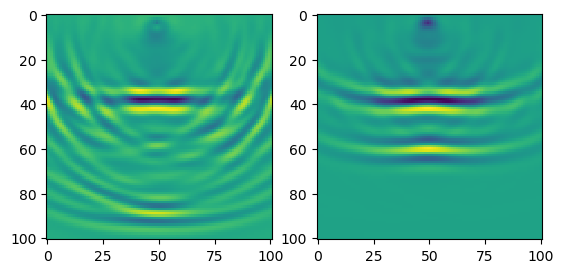

PyObject <matplotlib.image.AxesImage object at 0x14675b410>

In [13]:
subplot(121)
imshow(grad_w)
subplot(122)
imshow(grad_l2)